**Update 4/March/2021**: run repeated kfold for round 0+1+2 results, using partial replicates in ['../../data/Results_Microplate_partialTrue_normTrue_mean_roundRep_formatSeq_logTrue.csv'] with kernel normalisation, recorded in [repeated_kfold_wd_shift_round012.pickle]  
add another evaluation metirc converate rate, which is the percent of true labels inside of 95% prediced confidence interval. We also tested different values for sigma_0 (signal std in [this guide](https://drafts.distill.pub/gp/#gp-noise))
- num_split = 5
- num_repeat = 5
- s_list = [1]
- alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
- l_list =[6]
- sigma_0_list = [0.5, 1, 1.5, 2, 2.5]

## Goal

make the deicison whether to change any parameters in the pipeline for the last round design

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [2]:
# Parameters for pipeline 
# num_split = 5
# num_repeat = 10
# s_list = [0,1]
# alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))
# l_list = [3, 6]

with open('repeated_kfold_wd_shift_round012.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

l = 6

use xarray to store results
dimensions:

- train_test: results for train(0) or test(1) 
- eva_on: evaluate on sample labels(0) or average(1)
- eva_metric: mean square error(0) or r2 score(1) or coverage_rate(2)
- alpha (parameter of GPR, which adds to the diagonal of kernel matrix)
- l (length of kmer)
- s (shift length)
- repeat (nth repeat)
- fold (k-fold)

## Train performance

Report performance in terms the average score of repeats and folds.  
Visualisation can only do for two dimensions, so separate s = 0 and s = 1.

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the lower the better); Second col: eva_metric = R2 (the higher the better); Third col: coverage rate (the higher the better)

x, y axis:  
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5]   
sigma_0 = [0.5, 1, 1.5, 2, 2.5]

In [3]:
ave_train_result = result_pkl[0].mean(axis = -1).mean(axis = -1)

s = 1, i.e. wd kernel with 1 shift

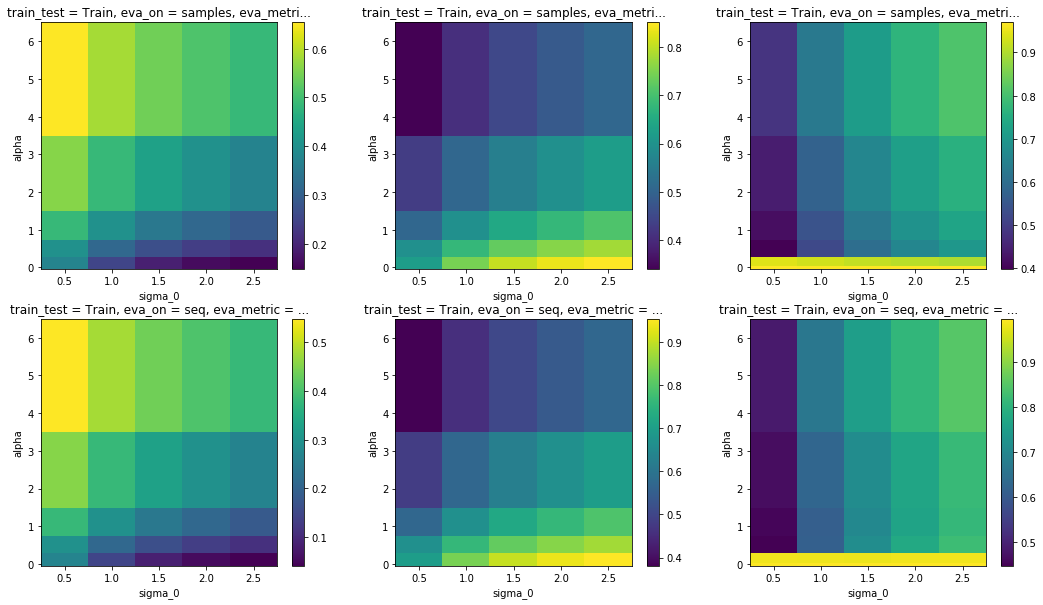

In [5]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_train_result[i][j].loc[dict(s = 1)].loc[dict(l=l)].plot(ax=a[i][j])

## Test performance

Report performance in terms the average score of repeats and folds.  

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the lower the better); Second col: eva_metric = R2 (the higher the better); Third col: coverage rate (the higher the better)

x, y axis:    
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5]   
sigma_0 = [0.5, 1, 1.5, 2, 2.5]

In [6]:
ave_test_result = result_pkl[1].mean(axis = -1).mean(axis = -1)

s = 1, i.e. wd kernel with 1 shift

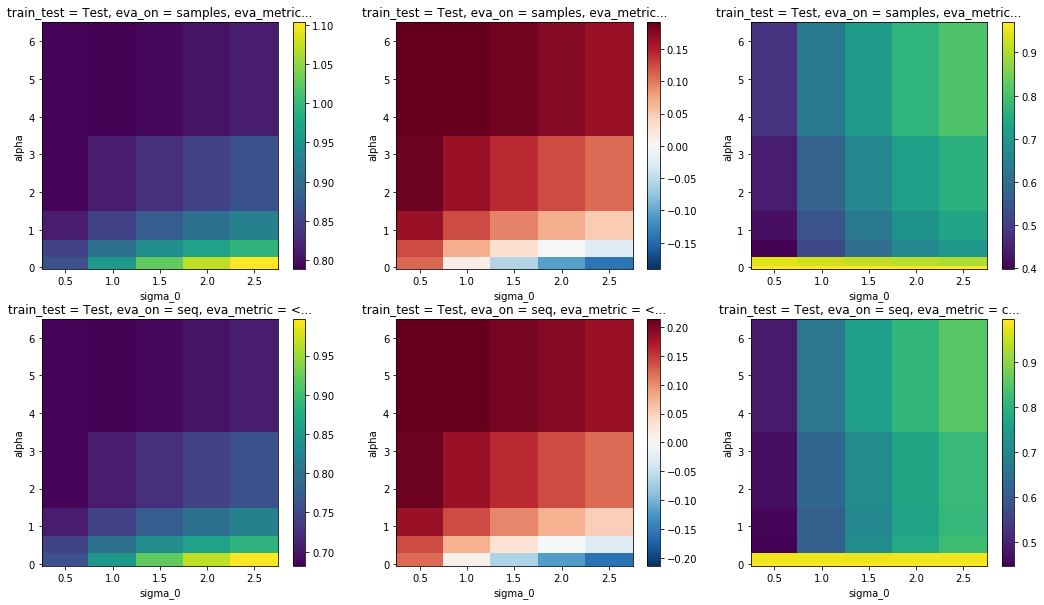

In [7]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_test_result[i][j].loc[dict(s = 1)].loc[dict(l=l)].plot(ax=a[i][j])

**Update 04/March/2021 Summary for repeated kfold results for round 0 + 1 + 2 data:**

changing alpha = 2 and sigma_0 = 1 to other choices does not give dramatic changes of testing performance, so we decide to stick on the previous choice. 

## RBF kernel Test Performance

We run the RBF kernel test performance in the following with the same process of repeated kfold. 
The r2_score wds kernel and RBF kernel has similar level of prediction accurary in terms of r2_score. 

In [14]:
with open('repeated_kfold_RBF_round012.pickle', 'rb') as handle:
    result_pkl_rbf = pickle.load(handle)

In [16]:
result_pkl_rbf.loc[dict(train_test = 'Test')].loc[dict(eva_metric=r2_score)].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (eva_on: 2, kernel_norm_flag: 1, centering_flag: 1, unit_norm_flag: 1, alpha: 1, rbf_lengthscale: 1, l: 1, s: 1, sigma_0: 1)>
array([[[[[[[[[0.06871283]]]]]]]],







       [[[[[[[[0.07595465]]]]]]]]])
Coordinates:
    train_test        <U5 'Test'
  * eva_on            (eva_on) <U7 'samples' 'seq'
    eva_metric        object <function r2_score at 0x7fc64bf7ef28>
  * kernel_norm_flag  (kernel_norm_flag) bool True
  * centering_flag    (centering_flag) bool False
  * unit_norm_flag    (unit_norm_flag) bool False
  * alpha             (alpha) int64 2
  * rbf_lengthscale   (rbf_lengthscale) int64 1
  * l                 (l) int64 6
  * s                 (s) int64 1
  * sigma_0           (sigma_0) int64 1

## Select parameters and show performance

based on above results, we choose

- l = 6
- alpha = 0,2,5
- s = 1
- sigma_0 = 2

Note: the following result only shows one random split of training and testing dataset. 

In [8]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'


df = pd.read_csv(Path)
df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


X train shape:  (1721, 20)
X test shape:  (71, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
<function mean_squared_error at 0x7fc64bf7ed08>
Train:  0.3014363431618728
Test:  0.9263185705957884
<function r2_score at 0x7fc64bf7ef28>
Train:  0.6524795331158393
Test:  0.02064558753351342
Test pred fit:  [ 0.00694992 -0.04053234]
Test ave fit:  [ 0.04681516 -1.73585592]
coverage rate: 
Train:  0.7977919814061593
Test:  0.6619718309859155


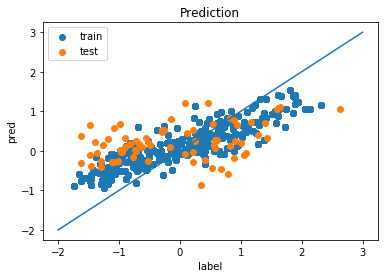

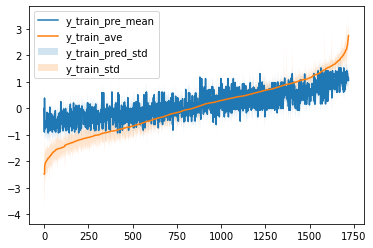

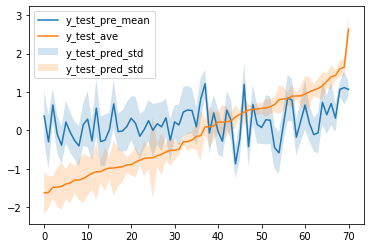

In [12]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
# kernel = 'RBF'
# embedding = 'onehot'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 2, eva_on='seqs', sigma_0=1)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()
gpr_train_samples.line_plot()

(array([ 2.,  0.,  0.,  3.,  8., 16., 20., 10.,  7.,  5.]),
 array([0.18967103, 0.24493989, 0.30020876, 0.35547762, 0.41074648,
        0.46601535, 0.52128421, 0.57655307, 0.63182194, 0.6870908 ,
        0.74235966]),
 <a list of 10 Patch objects>)

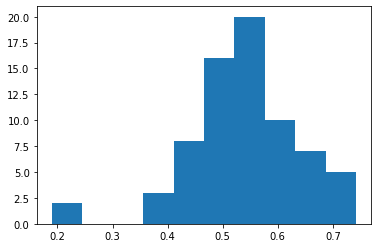

In [10]:
plt.hist(gpr_train_samples.test_df['pred std'])

## Conclusion

We decide to NOT change the pipeline parameters (other than beta). 

Again, both wds and RBF kernel do not give a reasonable good testing performance (both of them give testing r2_score around 0). So the evaluation comparison does not make too much sense in this case.  
Two ideas:
- we might want to change the evaluation method, for example, evaluate in terms of classification score other than regression. Like what we do in rec_design/round3_design/round2_prediction.ipynb
- to have a good prediction, we need to seek another embedding method (for future project).